In [1]:
import os
import sys 
sys.path.append('../../utilities/')
import data_utils, evaluation_utils
sys.path.append('../../src')
from dataset_class import dataset
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import metrics
from hmmlearn import hmm
import mrf_util
from mrf import MarkovRandomField
from GMM_GBR import GMM_MP
from scipy.special import entr

signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
GM12878_dataset = dataset('GM12878', 'hg19', 100000, '../../data/GM12878/hg19/Hi-C/GSE63525_GM12878_insitu_primary_30.hic',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/GM12878/hg19/Hi-C/res100000',
                 signals_names, '../../data/GM12878/hg19/genomic-assays/bin_100000/', 
                  '../../data/GM12878/hg19/res100000_datasets/',
                  '../../data/', '../../utilities/config.json')
GM12878_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/GM12878_100000_bins.txt')

/home/nedooshki/miniconda3/envs/IChDA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gene_expression_path = '../../data/GM12878/hg19/gene_expression/GM12878_genes_RPKM.txt'
RT_path = '../../data/GM12878/hg19/RT/six_phase/six_phases.txt'
CTCF_bedpe_path = '../../data/GM12878/hg19/ChIA-PET/CTCF/lifted_data'
RNAPII_bedpe_path = '../../data/GM12878/hg19/ChIA-PET/RNAPII/lifted_data'

In [3]:
RT_df = pd.read_csv(RT_path, sep = '\t', header = None)
RT_df.columns = ['chr_name', 'pos', 'G1', 'S1', 'S2', 'S3', 'S4', 'G2']
RT_df['pos'] = (RT_df['pos']/100000).astype(int)
RT_df = RT_df.groupby(['chr_name', 'pos'])[['G1', 'S1', 'S2', 'S3', 'S4', 'G2']].mean().reset_index()
bins = pd.read_csv('../../data/valid_bins/hg19/GM12878_100000_bins.txt', sep = '\t', header = None)
bins.columns = ['chr_name', 'start', 'end', 'index']
bins['pos'] = (bins['start']/100000).astype(int)
bins = bins[['chr_name', 'pos']]
RT_df = pd.merge(bins, RT_df, on = ['chr_name','pos'])

In [4]:
structural_signals_path = "../../data/GM12878/hg19/res100000_datasets/structural_signals.txt"
structural_signals = np.loadtxt(structural_signals_path)

functional_signals_path = "../../data/GM12878/hg19/res100000_datasets/signals.txt"
functional_signals = np.arcsinh(np.loadtxt(functional_signals_path))

combined_signals = np.concatenate([functional_signals, structural_signals], axis = 1)

signals_df = pd.DataFrame(functional_signals)
signals_df.columns = signals_names

#signals_df = pd.concat([signals_df,RT_df[['G1', 'S1', 'S2', 'S3', 'S4', 'G2']]], axis = 1)

In [56]:
k = 6
lengths = GM12878_dataset.get_chunks_lengths()

func_hmm = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
func_hmm.fit(functional_signals, lengths)
func_l = func_hmm.predict(functional_signals, lengths)

struct_hmm = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
struct_hmm.fit(structural_signals, lengths)
struct_l = struct_hmm.predict(structural_signals, lengths)

comb_hmm = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
comb_hmm.fit(combined_signals, lengths)
comb_l = comb_hmm.predict(combined_signals, lengths)

half_func_hmm = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
half_func_hmm.fit(functional_signals[:,[0,2,4,6,8,10]], lengths)
half_func_l = half_func_hmm.predict(functional_signals[:,[0,2,4,6,8,10]], lengths)

In [62]:
func_entropies = entr(np.round(func_hmm.predict_proba(functional_signals),2)).sum(axis = 1)
struct_entropies = entr(np.round(struct_hmm.predict_proba(structural_signals),2)).sum(axis = 1)
comb_entropies = entr(np.round(comb_hmm.predict_proba(combined_signals),2)).sum(axis = 1)
half_func_entropies = entr(np.round(half_func_hmm.predict_proba(functional_signals[:,[0,2,4,6,8,10]]),2)).sum(axis = 1)

In [89]:
print('average entropy of HMM_functional annotations: {}, HMM_structural annotations: {}, and HMM_combined annotations: {}.'.format(np.mean(func_entropies), np.mean(struct_entropies), np.mean(comb_entropies)))

average entropy of HMM_functional annotations: 0.1481095549599893, HMM_structural annotations: 0.05560550452660657, and HMM_combined annotations: 0.07402575273333689.


In [90]:
print('average entropy of HMM_functional annotations using 6 assays: {}.'.format(np.mean(half_func_entropies)))

average entropy of HMM_functional annotations using 6 assays: 0.22714671981298573.


In [6]:
annotation_dir = "../../data/GM12878/hg19/res100000_datasets/annotations/"

for k in [36]:
    
    annot_dir = os.path.join(annotation_dir, 'k{}_arcsinh'.format(k))
    if not os.path.exists(annot_dir):
        os.mkdir(annot_dir)

    lengths = GM12878_dataset.get_chunks_lengths()

    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(functional_signals, lengths)
    l = gmm_hmm_viterbi.predict(functional_signals, lengths)
    GM12878_dataset.write_annotation(l, 'HMM_functional', annot_dir)

    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(structural_signals, lengths)
    l = gmm_hmm_viterbi.predict(structural_signals, lengths)
    GM12878_dataset.write_annotation(l, 'HMM_structural', annot_dir)
    
    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(combined_signals, lengths)
    l = gmm_hmm_viterbi.predict(combined_signals, lengths)
    GM12878_dataset.write_annotation(l, 'HMM_combined', annot_dir)

In [10]:
# read annotations 
for k in [6,7,8,9,10,36]:   
    HMM_functional_path = "../../data/GM12878/hg19/res100000_datasets/annotations/k{}_arcsinh/HMM_functional_annotation.txt".format(k)
    HMM_structural_path = "../../data/GM12878/hg19/res100000_datasets/annotations/k{}_arcsinh/HMM_structural_annotation.txt".format(k)
    HMM_combined_path = "../../data/GM12878/hg19/res100000_datasets/annotations/k{}_arcsinh/HMM_combined_annotation.txt".format(k)
    GM12878_dataset.read_annotation(HMM_functional_path, 'HMM_functional_k{}'.format(k))
    GM12878_dataset.read_annotation(HMM_structural_path, 'HMM_structural_k{}'.format(k))
    GM12878_dataset.read_annotation(HMM_combined_path, 'HMM_combined_k{}'.format(k))
GM12878_dataset.read_annotation('../../data/GM12878/hg19/annotations/GM12878_SNIPER.bed', 'SNIPER')
GM12878_dataset.read_annotation('../../data/GM12878/hg19/annotations/GM12878_SCI_sub_compartments.bed', 'SCI')
GM12878_dataset.read_annotation('../../data/GM12878/hg19/annotations/GSE63525_GM12878_subcompartments.bed', 'SC')
GM12878_dataset.read_annotation('../../data/GM12878/hg19/annotations/GM12878_segway_gbr.bed', 'segway_GBR')

In [11]:
for k in [6,7,8,9,10,36]:
    signals_df['HMM_functional_k{}'.format(k)] = GM12878_dataset.labels['HMM_functional_k{}'.format(k)]
    signals_df['HMM_structural_k{}'.format(k)] = GM12878_dataset.labels['HMM_structural_k{}'.format(k)]
    signals_df['HMM_combined_k{}'.format(k)] = GM12878_dataset.labels['HMM_combined_k{}'.format(k)]
#signals_df['SNIPER'] = GM12878_dataset.labels['SNIPER']
#signals_df['SCI'] = GM12878_dataset.labels['SCI']
signals_df['SC'] = GM12878_dataset.labels['SC']
signals_df['segway_GBR'] = GM12878_dataset.labels['segway_GBR']
#signals_df.dropna(inplace = True)
#signals_df = signals_df[signals_df['SC'] != 'NA']

In [10]:
VEs = []
for annot in ['HMM_functional', 'HMM_structural', 'HMM_combined']:
    for k in [6,7,8,9,10]:
        temp = {'annot': annot, 'k': k}
        for signal in signals_names:
            ve = evaluation_utils.variance_explained(signals_df[signal].values,
                                                    signals_df['{}_k{}'.format(annot,k)])
            temp[signal] = ve
        VEs.append(temp)
VEs = pd.DataFrame(VEs)
#VEs.to_csv('results/signals_VEs.txt', sep = '\t', index = False)

In [14]:
ge_VEs = []
for annot in ['HMM_functional', 'HMM_structural', 'HMM_combined']:
    for k in [6,7,8,9,10]:
        annot_path = "../../data/GM12878/hg19/res100000_datasets/annotations/k{}_arcsinh/{}_annotation.txt".format(k, annot)
        ge_VE = evaluation_utils.gene_expression_ve(gene_expression_path, annot_path, 100000)
        ge_VEs.append({'annot': annot, 'k': k, 'ge_VE': ge_VE})
ge_VEs = pd.DataFrame(ge_VEs)
#ge_VEs.to_csv('results/ge_VEs.txt', sep = '\t', index = False)

In [16]:
RT_scores = []
for annot in ['HMM_functional', 'HMM_structural', 'HMM_combined']:
    for k in [6,7,8,9,10]:
        annot_path = "../../data/GM12878/hg19/res100000_datasets/annotations/k{}_arcsinh/{}_annotation.txt".format(k, annot)
        mean_VE, ARI = evaluation_utils.RT_scores(RT_path, annot_path, 100000)
        RT_scores.append({'annot': annot, 'k': k, 'mean_VE': mean_VE, 'ARI': ARI})
RT_scores = pd.DataFrame(RT_scores)
#RT_scores.to_csv('results/RT_scores.txt', sep = '\t', index = False)

In [18]:
K562_VEs = pd.read_csv('../K562/results/signals_VEs.txt', sep = '\t')
K562_ge_VEs = pd.read_csv('../K562/results/ge_VEs.txt', sep = '\t')
K562_RT_scores = pd.read_csv('../K562/results/RT_scores.txt', sep = '\t')

In [21]:
VEs = pd.read_csv('../GM12878/results/signals_VEs.txt', sep = '\t')
ge_VEs = pd.read_csv('../GM12878/results/ge_VEs.txt', sep = '\t')
RT_scores = pd.read_csv('../GM12878/results/RT_scores.txt', sep = '\t')

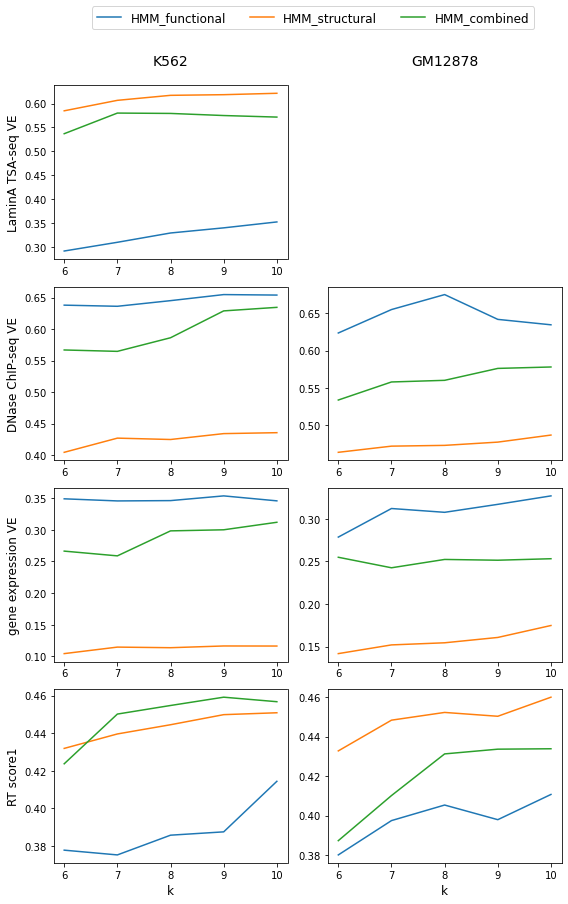

In [23]:
fig, axs = plt.subplots(4,2, figsize=(8,12))


sns.lineplot(data = K562_VEs, x = 'k', y='LaminA', hue = 'annot', ax = axs[0,0])
axs[0,0].set_ylabel('LaminA TSA-seq VE', size = 12)

sns.lineplot(data = K562_VEs, x = 'k', y='DNase', hue = 'annot', ax = axs[1,0])
axs[1,0].set_ylabel('DNase ChIP-seq VE', size = 12)

sns.lineplot(data = K562_ge_VEs, x = 'k', y='ge_VE', hue = 'annot', ax = axs[2,0])
axs[2,0].set_ylabel('gene expression VE', size = 12)

sns.lineplot(data = K562_RT_scores, x = 'k', y='mean_VE', hue = 'annot', ax = axs[3,0])
axs[3,0].set_ylabel('RT score1', size = 12)


sns.lineplot(data = VEs, x = 'k', y='DNase', hue = 'annot', ax = axs[1,1])
axs[1,1].set_ylabel('')

sns.lineplot(data = ge_VEs, x = 'k', y='ge_VE', hue = 'annot', ax = axs[2,1])
axs[2,1].set_ylabel('')

sns.lineplot(data = RT_scores, x = 'k', y='mean_VE', hue = 'annot', ax = axs[3,1])
axs[3,1].set_ylabel('')


for i in [1,2,3]:
    for j in [0,1]:
        axs[i,j].set_xlabel('')
        axs[i,j].get_legend().remove()
axs[0,0].get_legend().remove()
axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[3,0].set_xlabel('k', size = 12)
axs[3,1].set_xlabel('k', size = 12)
axs[0,1].axis('off')
        
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor = [0.55,1.05], ncol=3, fontsize = 12)

pad = 2

for ax, col in zip(axs[0], ['K562', 'GM12878']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 10*pad),
                xycoords='axes fraction', textcoords='offset pixels',
                size=14, ha='center', va='baseline')
    
fig.tight_layout()
fig.savefig(os.path.join('results', "best_k.png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

# enrichment plots

In [9]:
enrichments = {}
orders = {}
expr_stats = {}
coverages = {}
genes_nums = {}
SC_overlaps = {}
SC_pvalues = {}
GBR_overlaps = {}
GBR_pvalues = {}

k = 10

for input_type in ['functional', 'structural', 'combined']:
    path = "../../data/GM12878/hg19/res100000_datasets/annotations/k{}_arcsinh/HMM_{}_annotation.txt".format(k, input_type)
    enrichments['HMM_{}'.format(input_type)] = evaluation_utils.enrichment_scores_(signals_df, 
                                                                                   signals_names , 
                                                                                   'HMM_{}_k{}'.format(input_type, k))
    orders['HMM_{}'.format(input_type)] = np.argsort(enrichments['HMM_{}'.format(input_type)]['DNase'].values)




    expr_stats['HMM_{}'.format(input_type)] = evaluation_utils.gene_expr_stat(gene_expression_path, 
                                                                              path, 
                                                                              100000)
    coverages['HMM_{}'.format(input_type)] = evaluation_utils.coverage_stat(signals_df['HMM_{}_k{}'.format(input_type,k)])
    
    genes_nums['HMM_{}'.format(input_type)] = evaluation_utils.genes_num(gene_expression_path, path, 100000)
    fc, pval = evaluation_utils.overlap_fc(signals_df['HMM_{}_k{}'.format(input_type,k)],
                                                                            signals_df['SC'])
    SC_overlaps['HMM_{}'.format(input_type)] = round(fc.iloc[:-1,orders['HMM_{}'.format(input_type)][::-1]],2).transpose()
    SC_pvalues['HMM_{}'.format(input_type)] = np.array(pval.iloc[:-1,orders['HMM_{}'.format(input_type)][::-1]]).transpose()
    
    fc, pval = evaluation_utils.overlap_fc(signals_df['HMM_{}_k{}'.format(input_type,k)],
                                                                            signals_df['segway_GBR'])
    GBR_overlaps['HMM_{}'.format(input_type)] = round(fc.iloc[:,orders['HMM_{}'.format(input_type)][::-1]],2).transpose()
    GBR_pvalues['HMM_{}'.format(input_type)] = np.array(pval.iloc[:,orders['HMM_{}'.format(input_type)][::-1]]).transpose()
    

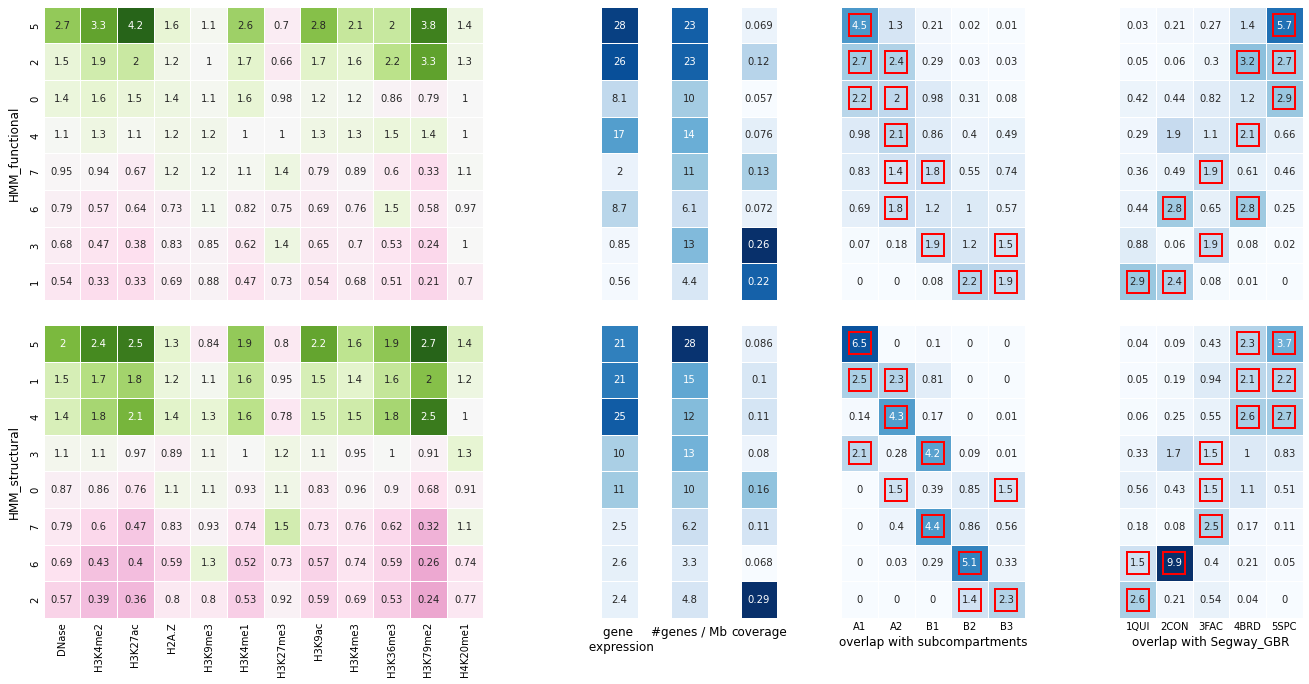

In [87]:
fig, axs = plt.subplots(2,6, figsize=(20,10), sharex = 'col', sharey = 'row',
                       gridspec_kw={'width_ratios': [12, 1, 1, 1, 5, 5],
                                   'height_ratios': [5,5]})

for m, method in enumerate(['HMM_functional', 'HMM_structural']):
    
    sns.heatmap(enrichments[method].iloc[orders[method][::-1],:], cmap="PiYG", center = 1, linewidths=.5, 
                square = True, cbar = False, annot = True, ax = axs[m,0])
    axs[m,0].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,0].set_yticklabels('')
    axs[m,0].set_ylabel(method, fontsize = 12, labelpad = 10)
    
    sns.heatmap(expr_stats[method].iloc[orders[method][::-1]], ax = axs[m,1], cmap = 'Blues', annot = True, 
                cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 30)
    axs[m,1].set_ylabel('')
    axs[m,1].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,1].set_xticklabels([])
    
    sns.heatmap(genes_nums[method].iloc[orders[method][::-1]], ax = axs[m,2], cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 28)
    axs[m,2].set_ylabel('')
    axs[m,2].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,2].set_xticklabels([])
    #axs[m,2].set_xlabel('#gene / Mb', fontsize = 12)
    

    sns.heatmap(coverages[method].iloc[orders[method][::-1]], ax = axs[m,3], cmap = 'Blues', annot = True, 
                cbar = False, square = True, linewidths=.5)
    axs[m,3].set_ylabel('')
    axs[m,3].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,3].set_xticklabels([])
    
    sns.heatmap(SC_overlaps[method], ax = axs[m,4], 
            cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
    axs[m,4].set_xlabel('')
    axs[m,4].set_ylabel('')
    axs[m,4].tick_params(axis=u'both', which=u'both',length=0)
    for i in range(SC_pvalues[method].shape[0]):
        for j in range(SC_pvalues[method].shape[1]):
            if SC_pvalues[method][i,j] < 2.2e-16:
                axs[m,4].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
    
    sns.heatmap(GBR_overlaps[method], ax = axs[m,5], 
            cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
    axs[m,5].set_xlabel('')
    axs[m,5].set_ylabel('')
    axs[m,5].tick_params(axis=u'both', which=u'both',length=0)
    for i in range(GBR_pvalues[method].shape[0]):
        for j in range(GBR_pvalues[method].shape[1]):
            if GBR_pvalues[method][i,j] < 2.2e-16:
                axs[m,5].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
                
axs[1,1].set_xlabel('gene \n expression', fontsize = 12)
axs[1,2].set_xlabel('#genes / Mb', fontsize = 12)
axs[1,3].set_xlabel('coverage', fontsize = 12)
axs[1,4].set_xlabel('overlap with subcompartments', fontsize = 12)
axs[1,5].set_xlabel('overlap with Segway_GBR', fontsize = 12)

fig.tight_layout(pad=2.5)
#fig.savefig('results/HMM_func_struct_k8.png', dpi = 300,
#            bbox_inches='tight',facecolor='white', transparent=False)

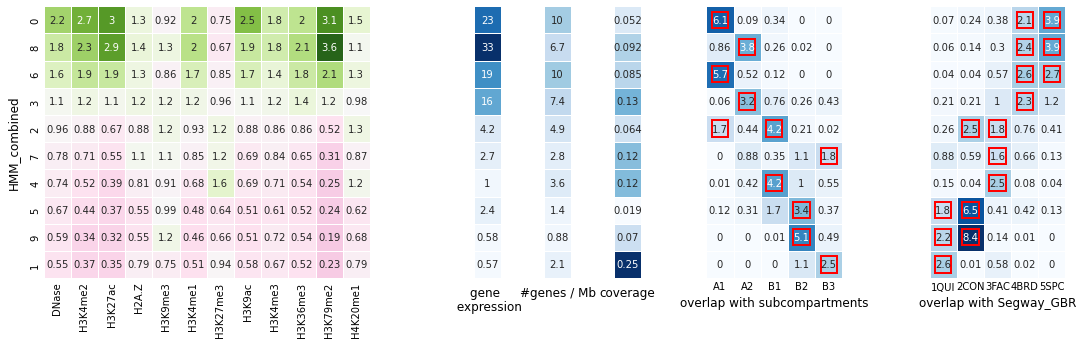

In [10]:
method = 'HMM_combined'
fig, axs = plt.subplots(1,6, figsize=(20,5), sharex = 'col', sharey = 'row',
                       gridspec_kw={'width_ratios': [12, 1, 1, 1, 5, 5],})
sns.heatmap(enrichments[method].iloc[orders[method][::-1],:], cmap="PiYG", center = 1, linewidths=.5, 
            square = True, cbar = False, annot = True, ax = axs[0])
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[0].set_yticklabels('')
axs[0].set_ylabel(method, fontsize = 12, labelpad = 10)

sns.heatmap(expr_stats[method].iloc[orders[method][::-1]], ax = axs[1], cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 30)
axs[1].set_ylabel('')
axs[1].tick_params(axis=u'both', which=u'both',length=0)
axs[1].set_xticklabels([])
axs[1].set_xlabel('gene \n expression', fontsize = 12)

sns.heatmap(genes_nums[method].iloc[orders[method][::-1]], ax = axs[2], cmap = 'Blues', annot = True, 
        cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 28)
axs[2].set_ylabel('')
axs[2].tick_params(axis=u'both', which=u'both',length=0)
axs[2].set_xticklabels([])
axs[2].set_xlabel('#genes / Mb', fontsize = 12)
#axs[m,2].set_xlabel('#gene / Mb', fontsize = 12)


sns.heatmap(coverages[method].iloc[orders[method][::-1]], ax = axs[3], cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5)
axs[3].set_ylabel('')
axs[3].tick_params(axis=u'both', which=u'both',length=0)
axs[3].set_xticklabels([])
axs[3].set_xlabel('coverage', fontsize = 12)

sns.heatmap(SC_overlaps[method], ax = axs[4], 
        cmap = 'Blues', annot = True, 
        cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
axs[4].set_xlabel('')
axs[4].set_ylabel('')
axs[4].tick_params(axis=u'both', which=u'both',length=0)
for i in range(SC_pvalues[method].shape[0]):
    for j in range(SC_pvalues[method].shape[1]):
        if SC_pvalues[method][i,j] < 2.2e-16:
            axs[4].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
axs[4].set_xlabel('overlap with subcompartments', fontsize = 12)
    
sns.heatmap(GBR_overlaps[method], ax = axs[5], 
        cmap = 'Blues', annot = True, 
        cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
axs[5].set_xlabel('')
axs[5].set_ylabel('')
axs[5].tick_params(axis=u'both', which=u'both',length=0)
for i in range(GBR_pvalues[method].shape[0]):
    for j in range(GBR_pvalues[method].shape[1]):
        if GBR_pvalues[method][i,j] < 2.2e-16:
            axs[5].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
axs[5].set_xlabel('overlap with Segway_GBR', fontsize = 12)
fig.savefig('results/HMM_combined_k10.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)

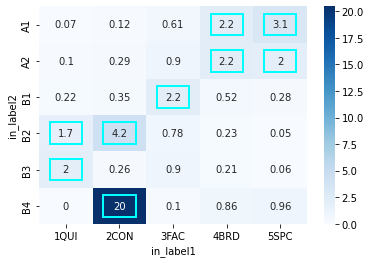

In [51]:
fc, pval = evaluation_utils.overlap_fc(signals_df['segway_GBR'], signals_df['SC'])
ax = sns.heatmap(round(fc,2), annot = True, cmap = 'Blues')
pval = np.array(pval)
for i in range(pval.shape[0]):
    for j in range(pval.shape[1]):
        if pval[i,j] < 2.2e-16:
            ax.add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='cyan', fc='none', lw=2))

In [42]:
evaluation_utils.overlap_per(signals_df['HMM_structural_k5'],                      
                                         signals_df['SC']).iloc[0,:]

in_label1
0    0.025936
1    0.846115
2    0.000000
3    0.408632
4    0.000000
Name: A1, dtype: float64

# alternatives

In [11]:
signals_path = "../../data/GM12878/hg19/res100000_datasets/signals.txt"
bins_path = "../../data/GM12878/hg19/res100000_datasets/bin.txt"
chain_path = '../../data/GM12878/hg19/res100000_datasets/interactions/chain_interactions.txt'
oe_intra_hic_path = '../../data/GM12878/hg19/res100000_datasets/interactions/oe_significant_intra_interactions_b2000.txt'
annotation_dir = "../../data/GM12878/hg19/res100000_datasets/annotations/"
annot_dir = os.path.join(annotation_dir, 'k{}_arcsinh'.format(k))

k = 8
'''
gmm_mp_args = {"i": signals_path, "e": chain_path, "g": bins_path, "r": 1, "n": k, 
              "il": 5, "ml": 10, "w": 10, "o": 'GM12878_res100000_mp', "mp": '../../alternatives/segway-gbr-master/measureProp/MP_large_scale'}
gmm_mp = GMM_MP(gmm_mp_args)
gmm_mp.write_mp_graph()
gmm_mp.GMM_train()
gmm_mp.GMM_inference(0)
for l in range(10):
    gmm_mp.write_mp_post(l+1)
    gmm_mp.run_measure_prop(l+1)
    gmm_mp.read_mp_post(l+1)
    gmm_mp.GMM_inference(l+1)
GM12878_dataset.write_annotation(gmm_mp.iters_labels[-1], 'GMM_GBR_chain', annot_dir)


gmm_mp_args = {"i": signals_path, "e": oe_intra_hic_path, "g": bins_path, "r": 1, "n": k, 
              "il": 5, "ml": 10, "w": 10, "o": 'GM12878_res100000_mp', "mp": '../../alternatives/segway-gbr-master/measureProp/MP_large_scale'}
gmm_mp = GMM_MP(gmm_mp_args)
gmm_mp.write_mp_graph()
gmm_mp.GMM_train()
gmm_mp.GMM_inference(0)
for l in range(10):
    gmm_mp.write_mp_post(l+1)
    gmm_mp.run_measure_prop(l+1)
    gmm_mp.read_mp_post(l+1)
    gmm_mp.GMM_inference(l+1)
GM12878_dataset.write_annotation(gmm_mp.iters_labels[-1], 'GMM_GBR_intra', annot_dir)

'''
mrf_signals = mrf_util.readData(signals_path)
mrf_bins = mrf_util.readBedGraph(bins_path)
n = mrf_signals.shape[0]

# SPIN with chain structure
mrf_hic = mrf_util.create_hic_matrix([chain_path], n, True)
hmrf = MarkovRandomField(n, mrf_hic, mrf_signals, 'mrf', k, 5, 0.01)
hmrf.init_gmm()
hmrf.init_trans()
hmrf.solve()
GM12878_dataset.write_annotation(hmrf.iters_labels[-1], 'SPIN_chain', annot_dir)


# SPIN with chain + intra-chromosomal O/E structure
mrf_hic = mrf_util.create_hic_matrix([chain_path,oe_intra_hic_path], n, True)
hmrf = MarkovRandomField(n, mrf_hic, mrf_signals, 'mrf', k, 5, 0.01)
hmrf.init_gmm()
hmrf.init_trans()
hmrf.solve()
GM12878_dataset.write_annotation(hmrf.iters_labels[-1], 'SPIN_chain_intra', annot_dir)

In [6]:
GM12878_dataset.read_annotation('../../data/GM12878/hg19/res100000_datasets/annotations/k8/GMM_GBR_chain_annotation.txt', 'GBR_chain')

In [7]:
GM12878_dataset.read_annotation('../../data/GM12878/hg19/res100000_datasets/annotations/k8/GMM_GBR_intra_annotation.txt', 'GBR_intra')

In [13]:
GM12878_dataset.read_annotation('../../data/GM12878/hg19/res100000_datasets/annotations/k8/SPIN_chain_intra_annotation.txt', 'SPIN_intra')

In [15]:
np.unique(GM12878_dataset.labels['SPIN_intra'], return_counts = True)

(array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype=object),
 array([12956,    17,    20,    21,   379,    11, 13287,    37]))

In [9]:
np.unique(GM12878_dataset.labels['GBR_chain'], return_counts = True)

(array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype=object),
 array([4284, 3280, 4205, 1455, 3242, 1608, 6445, 2209]))

In [10]:
np.unique(GM12878_dataset.labels['GBR_intra'], return_counts = True)

(array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype=object),
 array([7169, 5203, 1459, 1889, 4440, 3285,  689, 2594]))